**Program melatih model menggunakan Xception**

In [1]:
# Import library yang dibutuhkan
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import splitfolders

In [2]:
# Path direktori data latihan dan validasi
input_dir = 'C:/Users/RAIHAN FAIZ/Documents/Skripsi/Penelitian/Dataset/CK+48/dataset/'
output_dir = 'C:/Users/RAIHAN FAIZ/Documents/Skripsi/Penelitian/Percobaan/Percobaan D_Xception/CK+48/split/'
split_ratio = (0.7, 0.2, 0.1)  # Rasio pembagian train, val, test

# Split folder
splitfolders.ratio(input_dir, output=output_dir, seed=42, ratio=split_ratio)

Copying files: 981 files [00:11, 87.74 files/s]


In [3]:
# Path direktori data train, validasi, dan test
train_dir = output_dir + 'train'
val_dir = output_dir + 'val'
test_dir = output_dir + 'test'

In [4]:
# Parameter model dan pelatihan
input_shape = (299, 299, 3)  # Ubah input shape menjadi (299, 299, 3)
num_classes = 7
batch_size = 64
epochs = 100

In [5]:
# Membuat generator data latihan dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True  # Tambahkan pergeseran vertikal
)

# Membuat generator data validasi dan test tanpa augmentasi
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# Muat dan augmentasi data latihan
train_generator = train_datagen.flow_from_directory(
    train_dir,
    color_mode='rgb',
    target_size=(299, 299),  # Ubah target size menjadi (299, 299)
    batch_size=batch_size,
    class_mode='categorical'
)

# Muat data validasi
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    color_mode='rgb',
    target_size=(299, 299),  # Ubah target size menjadi (299, 299)
    batch_size=batch_size,
    class_mode='categorical'
)

# Muat data test
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    color_mode='rgb',
    target_size=(299, 299),  # Ubah target size menjadi (299, 299)
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 682 images belonging to 7 classes.
Found 193 images belonging to 7 classes.
Found 106 images belonging to 7 classes.


In [7]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Flatten, Dense

# Membangun model CNN dengan arsitektur Xception
base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False

model = keras.Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 dense (Dense)               (None, 256)               52429056  
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 73,292,335
Trainable params: 52,430,855
Non-trainable params: 20,861,480
_________________________________________________________________


In [8]:
# Kompilasi model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Callback untuk menghentikan pelatihan jika akurasi mencapai target
class MyCallback(keras.callbacks.Callback):
    def __init__(self, target_accuracy):
        super(MyCallback, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        val_accuracy = logs.get('val_accuracy')
        if val_accuracy is not None and val_accuracy >= self.target_accuracy:
            print(f"\nValidation accuracy reached {self.target_accuracy}. Training stopped.")
            self.model.stop_training = True

# Set target accuracy yang diinginkan
target_accuracy = 0.9
callbacks = [MyCallback(target_accuracy)]

In [10]:
# Latih model menggunakan generator data dan callback
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=callbacks
)

Epoch 1/100
10/10 [==============================] - 98s 9s/step - loss: 2.6579 - accuracy: 0.3301 - val_loss: 1.2973 - val_accuracy: 0.5573
Epoch 2/100
10/10 [==============================] - 70s 7s/step - loss: 1.4104 - accuracy: 0.5421 - val_loss: 1.2835 - val_accuracy: 0.5260
Epoch 3/100
10/10 [==============================] - 72s 7s/step - loss: 1.0855 - accuracy: 0.6141 - val_loss: 0.9627 - val_accuracy: 0.6042
Epoch 4/100
10/10 [==============================] - 69s 7s/step - loss: 0.9477 - accuracy: 0.6812 - val_loss: 0.7610 - val_accuracy: 0.6979
Epoch 5/100
10/10 [==============================] - 70s 7s/step - loss: 0.8504 - accuracy: 0.7006 - val_loss: 0.6394 - val_accuracy: 0.7760
Epoch 6/100
10/10 [==============================] - 69s 7s/step - loss: 0.7799 - accuracy: 0.7411 - val_loss: 0.6583 - val_accuracy: 0.7760
Epoch 7/100
10/10 [==============================] - 73s 7s/step - loss: 0.6495 - accuracy: 0.7735 - val_loss: 0.6420 - val_accuracy: 0.7708
Epoch 8/100
1

In [11]:
# Simpan model dengan metadata label
model.save('emotion_model_xception.h5')

**Menguji Model dengan Data Uji yang disiapkan**

In [12]:
import random
import os

test_samples_dir = 'C:/Users/RAIHAN FAIZ/Documents/Skripsi/Penelitian/Dataset/CK+48/split/test'
class_names = sorted(os.listdir(test_samples_dir))

# Memilih 5 sampel acak dari setiap kelas emosi
random_samples = {}
for class_name in class_names:
    class_dir = os.path.join(test_samples_dir, class_name)
    sample_files = os.listdir(class_dir)
    random_samples[class_name] = random.sample(sample_files, 5)

In [14]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Fungsi untuk menguji model pada satu sampel gambar
def predict_emotion(model, image_path):
    image = load_img(image_path, color_mode='rgb', target_size=(299, 299))
    image_array = img_to_array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)
    result = model.predict(image_array)
    return result[0]

# Proses pengujian
for class_name, samples in random_samples.items():
    print(f"\nEmosi: {class_name}")
    for sample_file in samples:
        sample_path = os.path.join(test_samples_dir, class_name, sample_file)
        result = predict_emotion(model, sample_path)
        predicted_class = class_names[np.argmax(result)]
        print(f"Gambar: {sample_file} => Prediksi: {predicted_class}, Skor: {result.max():.4f}")



Emosi: anger
1/1 [==============================] - 1s 1s/step
Gambar: S045_005_00000030.png => Prediksi: anger, Skor: 0.9358
1/1 [==============================] - 0s 168ms/step
Gambar: S072_005_00000017.png => Prediksi: anger, Skor: 0.9144
1/1 [==============================] - 0s 170ms/step
Gambar: S113_008_00000023.png => Prediksi: anger, Skor: 0.8090
1/1 [==============================] - 0s 180ms/step
Gambar: S037_003_00000022.png => Prediksi: anger, Skor: 0.7870
1/1 [==============================] - 0s 166ms/step
Gambar: S090_007_00000013.png => Prediksi: anger, Skor: 0.4820

Emosi: disgust
1/1 [==============================] - 0s 169ms/step
Gambar: S055_003_00000009.png => Prediksi: disgust, Skor: 0.9117
1/1 [==============================] - 0s 160ms/step
Gambar: S065_005_00000007.png => Prediksi: anger, Skor: 0.6457
1/1 [==============================] - 0s 170ms/step
Gambar: S108_006_00000020.png => Prediksi: disgust, Skor: 0.7444
1/1 [==============================] - 0s

**Plot Akurasi dan Loss, Classification Report, dan Confusion Matrix**

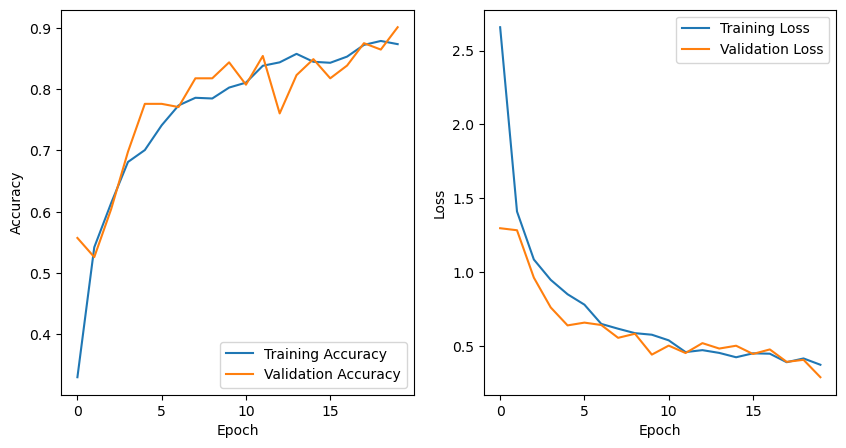

In [15]:
# Plot akurasi dan loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
# Evaluasi model pada data test
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

2/2 [==============================] - 8s 3s/step - loss: 0.3419 - accuracy: 0.8774
Test Loss: 0.3419276177883148
Test Accuracy: 0.8773584961891174


In [17]:
# Prediksi menggunakan model
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

2/2 [==============================] - 8s 3s/step


In [18]:
# Classification report
target_names = list(test_generator.class_indices.keys())
classification_rep = classification_report(y_true, y_pred_classes, target_names=target_names)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

       anger       0.72      0.93      0.81        14
     disgust       1.00      0.68      0.81        19
        fear       0.88      0.88      0.88         8
       happy       0.85      1.00      0.92        22
     nuetral       1.00      0.43      0.60         7
         sad       0.90      0.90      0.90        10
    surprise       0.93      1.00      0.96        26

    accuracy                           0.88       106
   macro avg       0.90      0.83      0.84       106
weighted avg       0.89      0.88      0.87       106



In [19]:
# Confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(confusion_mtx)

Confusion Matrix:
[[13  0  0  0  0  1  0]
 [ 5 13  0  1  0  0  0]
 [ 0  0  7  1  0  0  0]
 [ 0  0  0 22  0  0  0]
 [ 0  0  1  2  3  0  1]
 [ 0  0  0  0  0  9  1]
 [ 0  0  0  0  0  0 26]]


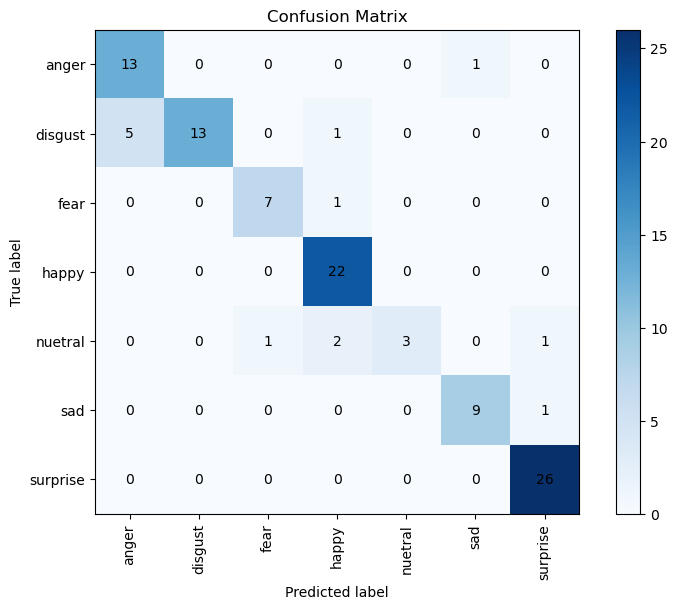

In [20]:
# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Menambahkan angka pada matriks
for i in range(confusion_mtx.shape[0]):
    for j in range(confusion_mtx.shape[1]):
        plt.text(j, i, str(confusion_mtx[i, j]), color='black', horizontalalignment='center', verticalalignment='center')

plt.show()